📥 Loading TSV files...
✅ Loaded 8 files, total rows: 42044

📊 Sample data (BEFORE cleaning):
            word  tag
28519  පරිහානියට    O
13367        පෙර    O
39931      ශ්‍රී  LOC
6243        8.30    O
35863    සංශෝධනය    O

🧹 CLEANING DATA
Before cleaning: 42044 rows

🔍 Data quality check:
  - Null words: 0
  - Null tags: 352
  - Empty words: 0

🏷️ Unique tags BEFORE cleaning:
tag
O      35737
ORG     2197
PER     2050
LOC     1707
NaN      352
O          1
Name: count, dtype: int64

✓ After removing NaN tags: 41692 rows
✓ After removing empty words: 41692 rows
✓ Stripped whitespace from tags
✓ Stripped whitespace from words

🏷️ Unique tags AFTER cleaning:
tag
O      35738
ORG     2197
PER     2050
LOC     1707
Name: count, dtype: int64

✅ Final cleaned dataset: 41692 rows

📚 Loading FastText model...
✅ FastText model loaded

🔧 Extracting FastText embeddings...
✅ Feature shape: (41692, 300)

🏷️ Label Mapping:
  0: LOC        -   1707 samples ( 4.09%)
  1: O          -  35738 samples 

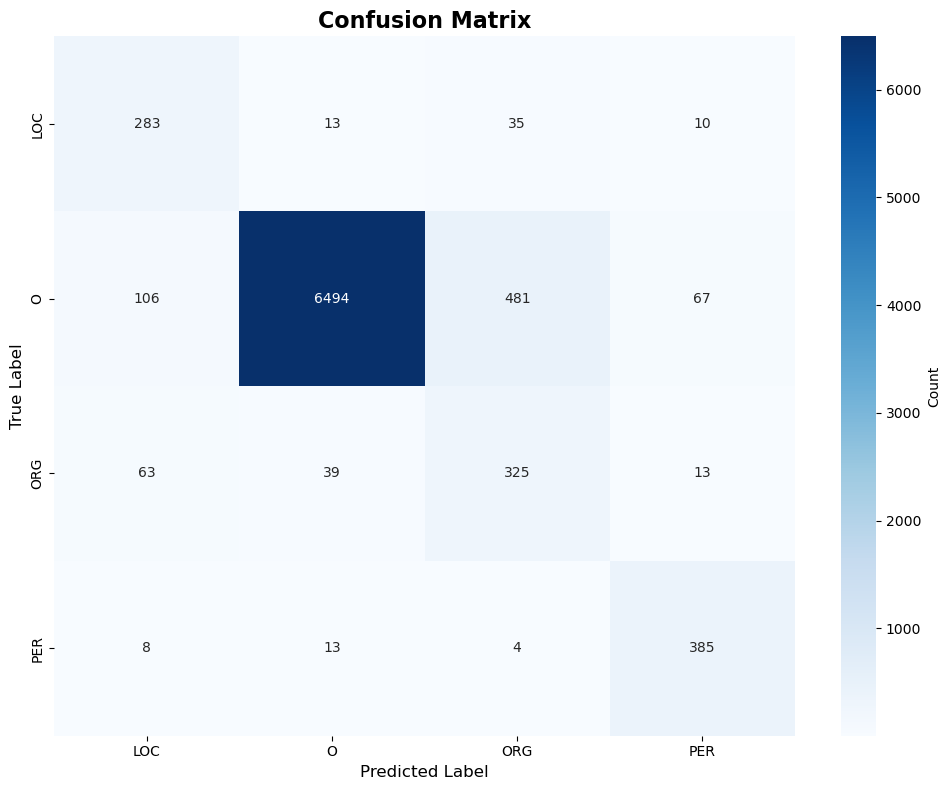

In [3]:
import pandas as pd
import numpy as np
import glob
import fasttext
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# ========================
# 1. LOAD DATASET
# ========================
print("📥 Loading TSV files...")
files = glob.glob("/Users/rashidahamed/Desktop/fyp/NERDATA/AnanyaSinhalaNERDataset/NewsPaper_41k/*.tsv")

dfs = [pd.read_csv(f, sep="\t", names=["word", "tag"]) for f in files]
data = pd.concat(dfs, ignore_index=True)

print(f"✅ Loaded {len(files)} files, total rows: {len(data)}")
print("\n📊 Sample data (BEFORE cleaning):")
print(data.sample(5))

# ========================
# 2. DATA CLEANING
# ========================
print("\n" + "="*70)
print("🧹 CLEANING DATA")
print("="*70)

print(f"Before cleaning: {len(data)} rows")

# Check for issues
print("\n🔍 Data quality check:")
print(f"  - Null words: {data['word'].isnull().sum()}")
print(f"  - Null tags: {data['tag'].isnull().sum()}")
print(f"  - Empty words: {(data['word'].str.len() == 0).sum()}")

# Show unique tags before cleaning
print(f"\n🏷️ Unique tags BEFORE cleaning:")
print(data['tag'].value_counts(dropna=False))

# CLEANING STEPS
# 1. Remove rows with NaN tags
data = data.dropna(subset=['tag'])
print(f"\n✓ After removing NaN tags: {len(data)} rows")

# 2. Remove rows with NaN or empty words
data = data.dropna(subset=['word'])
data = data[data['word'].str.len() > 0]
print(f"✓ After removing empty words: {len(data)} rows")

# 3. Strip whitespace from tags (fixes 'O ' vs 'O')
data['tag'] = data['tag'].str.strip()
print(f"✓ Stripped whitespace from tags")

# 4. Strip whitespace from words
data['word'] = data['word'].str.strip()
print(f"✓ Stripped whitespace from words")

# Show unique tags after cleaning
print(f"\n🏷️ Unique tags AFTER cleaning:")
tag_counts = data['tag'].value_counts()
print(tag_counts)

# Check for remaining issues
remaining_classes = tag_counts[tag_counts < 5]
if len(remaining_classes) > 0:
    print(f"\n⚠️ WARNING: {len(remaining_classes)} tags have fewer than 5 samples:")
    print(remaining_classes)
    print("\nRemoving these tags for stable training...")
    data = data[~data['tag'].isin(remaining_classes.index)]
    print(f"✓ After removing rare tags: {len(data)} rows")

print(f"\n✅ Final cleaned dataset: {len(data)} rows")

# ========================
# 3. LOAD FASTTEXT MODEL
# ========================
print("\n📚 Loading FastText model...")
ft_model = fasttext.load_model('/Users/rashidahamed/Desktop/fyp/fastText/cc.si.300.bin')
print("✅ FastText model loaded")

# ========================
# 4. EXTRACT FEATURES
# ========================
print("\n🔧 Extracting FastText embeddings...")

Xtest = data['word'].values
y_tags = data['tag'].values
X = []

for word in Xtest:
    embedding = ft_model.get_word_vector(word)
    X.append(embedding)

X = np.array(X)
print(f"✅ Feature shape: {X.shape}")

# ========================
# 5. ENCODE LABELS
# ========================
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_tags)

print(f"\n🏷️ Label Mapping:")
print("="*70)
for i, label in enumerate(label_encoder.classes_):
    count = (y_encoded == i).sum()
    percentage = (count / len(y_encoded)) * 100
    print(f"  {i}: {label:<10} - {count:>6} samples ({percentage:>5.2f}%)")

# ========================
# 6. TRAIN-TEST SPLIT
# ========================
print("\n📦 Splitting data...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"  Train: {len(X_train)} samples")
print(f"  Test:  {len(X_test)} samples")

print("\n📊 Train set distribution:")
train_counts = pd.Series(y_train).value_counts().sort_index()
for idx, count in train_counts.items():
    label = label_encoder.classes_[idx]
    print(f"  {label:<10}: {count:>6} samples")

# ========================
# 7. TRAIN MODEL
# ========================
print("\n🤖 Training SVM model...")
print("  Parameters: C=10, kernel='rbf', class_weight='balanced'")

clf = make_pipeline(
    StandardScaler(),
    svm.SVC(class_weight='balanced', C=10, kernel='rbf', probability=True)
)

clf.fit(X_train, y_train)
print("✅ Model trained successfully!")

# ========================
# 8. EVALUATE MODEL
# ========================
print("\n📊 Evaluating model...")
y_pred = clf.predict(X_test)

print("\n" + "="*70)
print("CLASSIFICATION REPORT")
print("="*70)
report = classification_report(
    y_test, y_pred,
    target_names=label_encoder.classes_,
    digits=4,
    zero_division=0
)
print(report)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
print("\n✅ Saved confusion_matrix.png")

# Overall accuracy
accuracy = (y_pred == y_test).mean()
print(f"\n🎯 Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# ========================
# 9. PREDICTION FUNCTION
# ========================
def predict_tags(sentence, return_confidence=False):
    """
    Predict NER tags for a sentence
    
    Args:
        sentence: Input sentence in Sinhala
        return_confidence: If True, return confidence scores
    
    Returns:
        List of (word, tag) or (word, tag, confidence) tuples
    """
    words = sentence.split()
    results = []
    
    for word in words:
        # Get embedding
        embedding = ft_model.get_word_vector(word)
        
        # Predict
        tag_encoded = clf.predict([embedding])[0]
        tag = label_encoder.inverse_transform([tag_encoded])[0]
        
        if return_confidence:
            proba = clf.predict_proba([embedding])[0]
            confidence = proba[tag_encoded]
            results.append((word, tag, confidence))
        else:
            results.append((word, tag))
    
    return results

def format_predictions(predictions, show_confidence=False):
    """Pretty print predictions"""
    print("\n" + "="*70)
    print("🎯 NER PREDICTIONS")
    print("="*70)
    
    if show_confidence:
        print(f"{'Word':<25} {'Tag':<10} {'Confidence'}")
        print("-"*70)
        for word, tag, conf in predictions:
            # Color indicators
            if conf > 0.85:
                indicator = "🟢"
            elif conf > 0.70:
                indicator = "🟡"
            else:
                indicator = "🔴"
            
            # Highlight entities
            if tag != 'O':
                tag_display = f"✨ {tag}"
            else:
                tag_display = tag
            
            print(f"{word:<25} {tag_display:<10} {indicator} {conf:.4f}")
    else:
        print(f"{'Word':<25} {'Tag'}")
        print("-"*70)
        for word, tag in predictions:
            if tag != 'O':
                tag_display = f"✨ {tag}"
            else:
                tag_display = tag
            print(f"{word:<25} {tag_display}")
    
    print("="*70)

def extract_entities(predictions):
    """Extract and group named entities"""
    entities = {}
    current_entity = []
    current_tag = None
    
    for item in predictions:
        word = item[0]
        tag = item[1]
        
        if tag != 'O':
            if tag == current_tag:
                # Continue current entity
                current_entity.append(word)
            else:
                # Save previous entity
                if current_entity:
                    if current_tag not in entities:
                        entities[current_tag] = []
                    entities[current_tag].append(' '.join(current_entity))
                
                # Start new entity
                current_entity = [word]
                current_tag = tag
        else:
            # Save and reset
            if current_entity:
                if current_tag not in entities:
                    entities[current_tag] = []
                entities[current_tag].append(' '.join(current_entity))
                current_entity = []
                current_tag = None
    
    # Don't forget last entity
    if current_entity and current_tag:
        if current_tag not in entities:
            entities[current_tag] = []
        entities[current_tag].append(' '.join(current_entity))
    
    return entities

# ========================
# 10. TEST PREDICTIONS
# ========================
print("\n" + "="*70)
print("🧪 TESTING PREDICTIONS")
print("="*70)

test_sentences = [
    "කෙහෙල්බද්දර පද්මේ ගැන තවත් අනාවරණයක්",
    "ජනාධිපති රනිල් වික්‍රමසිංහ කොළඹ පැමිණියේය",
    "ශ්‍රී ලංකාව ඉන්දියාව සමඟ ක්‍රිකට් තරගයක් පැවැත්වීය",
    "කිම් ජොං අන් ජනපති ට්‍රම්ප්ට ඉක්මන් සුවය පතයි"
]

for i, sentence in enumerate(test_sentences, 1):
    print(f"\n{'─'*70}")
    print(f"📝 Test {i}: {sentence}")
    print('─'*70)
    
    # Predict
    predictions = predict_tags(sentence, return_confidence=True)
    format_predictions(predictions, show_confidence=True)
    
    # Extract entities
    entities = extract_entities(predictions)
    if entities:
        print("\n📋 Extracted Entities:")
        for entity_type, entity_list in entities.items():
            for entity in entity_list:
                print(f"  • {entity_type}: {entity}")
    else:
        print("\n📋 No named entities detected")

# ========================
# 11. SAVE MODEL
# ========================
import pickle

print("\n💾 Saving model and encoder...")
with open('ner_model_cleaned.pkl', 'wb') as f:
    pickle.dump(clf, f)

with open('label_encoder_cleaned.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

print("✅ Saved: ner_model_cleaned.pkl")
print("✅ Saved: label_encoder_cleaned.pkl")

# ========================
# 12. SUMMARY
# ========================
print("\n" + "="*70)
print("📊 SUMMARY")
print("="*70)
print(f"✓ Dataset: {len(data)} samples after cleaning")
print(f"✓ Features: {X.shape[1]}-dimensional FastText embeddings")
print(f"✓ Classes: {len(label_encoder.classes_)} ({', '.join(label_encoder.classes_)})")
print(f"✓ Model: SVM with RBF kernel")
print(f"✓ Accuracy: {accuracy:.4f}")
print("\n🎉 Pipeline completed successfully!")

print("\n" + "="*70)
print("💡 USAGE")
print("="*70)
print("""
# Load saved model:
import pickle
import fasttext

with open('ner_model_cleaned.pkl', 'rb') as f:
    clf = pickle.load(f)

with open('label_encoder_cleaned.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

ft_model = fasttext.load_model('/Users/rashidahamed/Desktop/fyp/fastText/cc.si.300.bin')

# Then use predict_tags() function:
sentence = "Your Sinhala sentence here"
predictions = predict_tags(sentence, return_confidence=True)
format_predictions(predictions, show_confidence=True)
""")

In [4]:
sentence = "කොළඹ ජාතික අක්ෂි රෝහලට ගිය ජනමාධ්‍යවේදීන් කෙහෙල්බද්දර පද්මේ ගැන තවත් අනාවරණයක්"
predictions = predict_tags(sentence)
print(predictions)

[('කොළඹ', 'LOC'), ('ජාතික', 'ORG'), ('අක්ෂි', 'O'), ('රෝහලට', 'ORG'), ('ගිය', 'O'), ('ජනමාධ්\u200dයවේදීන්', 'O'), ('කෙහෙල්බද්දර', 'PER'), ('පද්මේ', 'PER'), ('ගැන', 'O'), ('තවත්', 'O'), ('අනාවරණයක්', 'O')]


In [ ]:
import random
import numpy as np
from collections import defaultdict
import fasttext
from googletrans import Translator
import pickle
import pandas as pd
from tqdm import tqdm

# =====================================================
# SMART SYNONYM FINDER USING TRANSLATION + FASTTEXT
# =====================================================

class SmartSinhalaAugmenter:
    """
    Intelligent Sinhala data augmentation using:
    1. Sinhala → English translation
    2. FastText similarity in English
    3. English synonyms → Sinhala translation
    """
    
    def __init__(self, fasttext_model_path, ner_predict_func=None):
        """
        Initialize augmenter
        
        Args:
            fasttext_model_path: Path to FastText model (English or Sinhala)
            ner_predict_func: Optional NER prediction function to preserve entities
        """
        print("🔧 Initializing Smart Sinhala Augmenter...")
        
        # Load FastText model
        print(f"📚 Loading FastText model from {fasttext_model_path}")
        self.ft_model = fasttext.load_model(fasttext_model_path)
        
        # Initialize translator
        print("🌐 Initializing Google Translator...")
        self.translator = Translator()
        
        # NER function (optional - to avoid replacing entities)
        self.ner_predict = ner_predict_func
        
        # Cache for translations to avoid repeated API calls
        self.translation_cache = {}
        self.synonym_cache = {}
        
        print("✅ Augmenter initialized successfully!\n")
    
    def translate_word(self, word, src='si', dest='en'):
        """Translate a word with caching"""
        cache_key = f"{word}_{src}_{dest}"
        
        if cache_key in self.translation_cache:
            return self.translation_cache[cache_key]
        
        try:
            result = self.translator.translate(word, src=src, dest=dest)
            translated = result.text.lower()
            self.translation_cache[cache_key] = translated
            return translated
        except Exception as e:
            print(f"⚠️ Translation error for '{word}': {e}")
            return None
    
    def find_english_synonyms(self, english_word, top_k=5, similarity_threshold=0.5):
        """
        Find similar words in English using FastText
        
        Args:
            english_word: English word to find synonyms for
            top_k: Number of similar words to retrieve
            similarity_threshold: Minimum similarity score (0-1)
        
        Returns:
            List of (word, similarity) tuples
        """
        cache_key = f"{english_word}_{top_k}_{similarity_threshold}"
        
        if cache_key in self.synonym_cache:
            return self.synonym_cache[cache_key]
        
        try:
            # Get nearest neighbors from FastText
            neighbors = self.ft_model.get_nearest_neighbors(english_word, k=top_k*2)
            
            # Filter by similarity threshold and remove duplicates
            synonyms = []
            seen = set([english_word])
            
            for similarity, word in neighbors:
                # Clean the word (remove special chars, numbers)
                word_clean = ''.join(c for c in word if c.isalpha()).lower()
                
                if (similarity >= similarity_threshold and 
                    word_clean not in seen and 
                    len(word_clean) > 2):
                    synonyms.append((word_clean, similarity))
                    seen.add(word_clean)
                
                if len(synonyms) >= top_k:
                    break
            
            self.synonym_cache[cache_key] = synonyms
            return synonyms
            
        except Exception as e:
            print(f"⚠️ Error finding synonyms for '{english_word}': {e}")
            return []
    
    def get_sinhala_synonyms(self, sinhala_word, top_k=3, similarity_threshold=0.5):
        """
        Get Sinhala synonyms using translation pipeline:
        Sinhala → English → Find synonyms → Back to Sinhala
        
        Args:
            sinhala_word: Sinhala word to find synonyms for
            top_k: Number of synonyms to return
            similarity_threshold: Minimum similarity for English synonyms
        
        Returns:
            List of Sinhala synonym words
        """
        # Step 1: Translate Sinhala → English
        english_word = self.translate_word(sinhala_word, src='si', dest='en')
        
        if not english_word:
            return []
        
        # Step 2: Find English synonyms using FastText
        english_synonyms = self.find_english_synonyms(
            english_word, 
            top_k=top_k*2,  # Get more candidates
            similarity_threshold=similarity_threshold
        )
        
        if not english_synonyms:
            return []
        
        # Step 3: Translate synonyms back to Sinhala
        sinhala_synonyms = []
        for eng_syn, similarity in english_synonyms:
            sinhala_syn = self.translate_word(eng_syn, src='en', dest='si')
            
            if sinhala_syn and sinhala_syn != sinhala_word:
                sinhala_synonyms.append(sinhala_syn)
            
            if len(sinhala_synonyms) >= top_k:
                break
        
        return sinhala_synonyms
    
    def should_replace_word(self, word, ner_tag):
        """
        Decide if a word should be replaced based on NER tag
        
        Args:
            word: The word to check
            ner_tag: NER tag (PER, LOC, ORG, O, etc.)
        
        Returns:
            Boolean indicating if word should be replaced
        """
        # Don't replace named entities (PER, LOC, ORG, DATE, etc.)
        protected_tags = ['PER', 'LOC', 'ORG', 'DATE', 'TIME', 'MONEY']
        
        if ner_tag in protected_tags:
            return False
        
        # Don't replace very short words (likely particles)
        if len(word) <= 2:
            return False
        
        return True
    
    def augment_sentence(self, sentence, num_augmentations=3, 
                        replacement_rate=0.3, preserve_entities=True):
        """
        Augment a Sinhala sentence by replacing words with synonyms
        
        Args:
            sentence: Input Sinhala sentence
            num_augmentations: Number of augmented versions to create
            replacement_rate: Percentage of words to replace (0-1)
            preserve_entities: If True, don't replace named entities
        
        Returns:
            List of augmented sentences
        """
        words = sentence.split()
        
        # Get NER tags if preserve_entities is True
        ner_tags = None
        if preserve_entities and self.ner_predict:
            try:
                predictions = self.ner_predict(sentence)
                ner_tags = [tag for _, tag in predictions]
            except Exception as e:
                print(f"⚠️ NER prediction failed: {e}")
                ner_tags = ['O'] * len(words)
        else:
            ner_tags = ['O'] * len(words)
        
        augmented_sentences = []
        
        for aug_idx in range(num_augmentations):
            new_words = words.copy()
            
            # Determine which words to replace
            num_replacements = max(1, int(len(words) * replacement_rate))
            
            # Get indices of replaceable words
            replaceable_indices = [
                i for i, (word, tag) in enumerate(zip(words, ner_tags))
                if self.should_replace_word(word, tag)
            ]
            
            if not replaceable_indices:
                augmented_sentences.append(sentence)
                continue
            
            # Randomly select words to replace
            indices_to_replace = random.sample(
                replaceable_indices,
                min(num_replacements, len(replaceable_indices))
            )
            
            # Replace selected words with synonyms
            for idx in indices_to_replace:
                original_word = words[idx]
                
                # Get synonyms
                synonyms = self.get_sinhala_synonyms(
                    original_word,
                    top_k=3,
                    similarity_threshold=0.4
                )
                
                if synonyms:
                    # Randomly pick one synonym
                    new_words[idx] = random.choice(synonyms)
            
            augmented_sentence = ' '.join(new_words)
            augmented_sentences.append(augmented_sentence)
        
        return augmented_sentences
    
    def augment_dataset(self, sentences, labels, num_augmentations_per_sample=2,
                       replacement_rate=0.3, preserve_entities=True, 
                       show_progress=True):
        """
        Augment an entire dataset
        
        Args:
            sentences: List of Sinhala sentences
            labels: List of corresponding labels
            num_augmentations_per_sample: Augmentations per sentence
            replacement_rate: Percentage of words to replace
            preserve_entities: Whether to preserve named entities
            show_progress: Show progress bar
        
        Returns:
            augmented_sentences, augmented_labels
        """
        augmented_sentences = []
        augmented_labels = []
        
        iterator = tqdm(zip(sentences, labels), total=len(sentences)) if show_progress else zip(sentences, labels)
        
        for sentence, label in iterator:
            # Keep original
            augmented_sentences.append(sentence)
            augmented_labels.append(label)
            
            # Generate augmentations
            aug_sents = self.augment_sentence(
                sentence,
                num_augmentations=num_augmentations_per_sample,
                replacement_rate=replacement_rate,
                preserve_entities=preserve_entities
            )
            
            # Add augmentations
            for aug_sent in aug_sents:
                augmented_sentences.append(aug_sent)
                augmented_labels.append(label)
        
        return augmented_sentences, augmented_labels


# =====================================================
# TEXT CLASSIFICATION WITH AUGMENTED DATA
# =====================================================

class AugmentedTextClassifier:
    """
    Text classifier that uses augmented training data
    """
    
    def __init__(self, fasttext_model, classifier_model=None):
        """
        Initialize classifier
        
        Args:
            fasttext_model: FastText model for embeddings
            classifier_model: Pre-trained classifier (optional)
        """
        self.ft_model = fasttext_model
        self.classifier = classifier_model
        self.label_encoder = None
    
    def extract_features(self, sentences):
        """Extract FastText embeddings for sentences"""
        embeddings = []
        
        for sentence in sentences:
            # Get average of word embeddings
            words = sentence.split()
            word_vectors = [self.ft_model.get_word_vector(word) for word in words]
            
            if word_vectors:
                sentence_embedding = np.mean(word_vectors, axis=0)
            else:
                sentence_embedding = np.zeros(self.ft_model.get_dimension())
            
            embeddings.append(sentence_embedding)
        
        return np.array(embeddings)
    
    def train_with_augmentation(self, sentences, labels, augmenter, 
                               num_augmentations=2, test_size=0.2):
        """
        Train classifier with data augmentation
        
        Args:
            sentences: Training sentences
            labels: Training labels
            augmenter: SmartSinhalaAugmenter instance
            num_augmentations: Number of augmentations per sample
            test_size: Test split size
        """
        from sklearn.model_selection import train_test_split
        from sklearn.preprocessing import LabelEncoder
        from sklearn.svm import SVC
        from sklearn.pipeline import make_pipeline
        from sklearn.preprocessing import StandardScaler
        from sklearn.metrics import classification_report
        
        print("🔄 Augmenting training data...")
        aug_sentences, aug_labels = augmenter.augment_dataset(
            sentences, labels,
            num_augmentations_per_sample=num_augmentations,
            replacement_rate=0.3,
            preserve_entities=True
        )
        
        print(f"✅ Dataset augmented: {len(sentences)} → {len(aug_sentences)} samples")
        
        # Encode labels
        self.label_encoder = LabelEncoder()
        y_encoded = self.label_encoder.fit_transform(aug_labels)
        
        print(f"\n📊 Label distribution:")
        for label, count in zip(*np.unique(y_encoded, return_counts=True)):
            label_name = self.label_encoder.inverse_transform([label])[0]
            print(f"  {label_name}: {count} samples")
        
        # Extract features
        print("\n🔧 Extracting features...")
        X = self.extract_features(aug_sentences)
        
        # Split data
        print("\n📦 Splitting data...")
        X_train, X_test, y_train, y_test = train_test_split(
            X, y_encoded, test_size=test_size, random_state=42, stratify=y_encoded
        )
        
        # Train classifier
        print("\n🤖 Training classifier...")
        self.classifier = make_pipeline(
            StandardScaler(),
            SVC(class_weight='balanced', C=10, kernel='rbf', probability=True)
        )
        
        self.classifier.fit(X_train, y_train)
        print("✅ Training complete!")
        
        # Evaluate
        print("\n📊 Evaluating on test set...")
        y_pred = self.classifier.predict(X_test)
        
        print("\n" + "="*70)
        print("CLASSIFICATION REPORT")
        print("="*70)
        report = classification_report(
            y_test, y_pred,
            target_names=self.label_encoder.classes_,
            digits=4
        )
        print(report)
        
        return self.classifier
    
    def predict(self, sentences):
        """
        Predict labels for sentences
        
        Args:
            sentences: List of sentences or single sentence
        
        Returns:
            Predicted labels
        """
        if isinstance(sentences, str):
            sentences = [sentences]
        
        X = self.extract_features(sentences)
        y_pred = self.classifier.predict(X)
        labels = self.label_encoder.inverse_transform(y_pred)
        
        if len(labels) == 1:
            return labels[0]
        return labels
    
    def predict_with_confidence(self, sentence):
        """Predict with confidence scores"""
        X = self.extract_features([sentence])
        y_pred = self.classifier.predict(X)[0]
        proba = self.classifier.predict_proba(X)[0]
        
        label = self.label_encoder.inverse_transform([y_pred])[0]
        confidence = proba[y_pred]
        
        # Get all class probabilities
        all_probs = {
            self.label_encoder.inverse_transform([i])[0]: prob
            for i, prob in enumerate(proba)
        }
        
        return label, confidence, all_probs


# =====================================================
# USAGE EXAMPLE
# =====================================================

def example_usage():
    """
    Complete example of data augmentation and classification
    """
    
    print("="*70)
    print("SINHALA DATA AUGMENTATION & TEXT CLASSIFICATION EXAMPLE")
    print("="*70)
    
    # ========================================
    # 1. INITIALIZE AUGMENTER
    # ========================================
    print("\n📌 STEP 1: Initialize Augmenter")
    print("-"*70)
    
    # Load your NER model for entity preservation (optional)
    try:
        with open('ner_model_cleaned.pkl', 'rb') as f:
            ner_clf = pickle.load(f)
        with open('label_encoder_cleaned.pkl', 'rb') as f:
            ner_label_encoder = pickle.load(f)
        
        # Load FastText
        ft_model_si = fasttext.load_model('/Users/rashidahamed/Desktop/fyp/fastText/cc.si.300.bin')
        
        # Define NER predict function
        def ner_predict(sentence):
            words = sentence.split()
            predictions = []
            for word in words:
                embedding = ft_model_si.get_word_vector(word)
                tag_encoded = ner_clf.predict([embedding])[0]
                tag = ner_label_encoder.inverse_transform([tag_encoded])[0]
                predictions.append((word, tag))
            return predictions
        
        print("✅ NER model loaded for entity preservation")
        
    except Exception as e:
        print(f"⚠️ Could not load NER model: {e}")
        print("   Proceeding without entity preservation...")
        ner_predict = None
        ft_model_si = fasttext.load_model('/Users/rashidahamed/Desktop/fyp/fastText/cc.si.300.bin')
    
    # Initialize augmenter
    # Note: You can use English FastText model for better synonym finding
    # Download from: https://fasttext.cc/docs/en/crawl-vectors.html
    augmenter = SmartSinhalaAugmenter(
        fasttext_model_path='/Users/rashidahamed/Desktop/fyp/fastText/cc.si.300.bin',  # or use English model
        ner_predict_func=ner_predict
    )
    
    # ========================================
    # 2. TEST SINGLE SENTENCE AUGMENTATION
    # ========================================
    print("\n📌 STEP 2: Test Single Sentence Augmentation")
    print("-"*70)
    
    test_sentence = "කොළඹ ජාතික අක්ෂි රෝහලට ගිය ජනමාධ්‍යවේදීන් කෙහෙල්බද්දර පද්මේ ගැන තවත් අනාවරණයක්"
    
    print(f"Original: {test_sentence}\n")
    
    augmented = augmenter.augment_sentence(
        test_sentence,
        num_augmentations=3,
        replacement_rate=0.3,
        preserve_entities=True
    )
    
    for i, aug_sent in enumerate(augmented, 1):
        print(f"Aug {i}:   {aug_sent}")
    
    # ========================================
    # 3. AUGMENT DATASET
    # ========================================
    print("\n📌 STEP 3: Augment Training Dataset")
    print("-"*70)
    
    # Example dataset (replace with your actual data)
    train_sentences = [
        "ජනාධිපති රනිල් වික්‍රමසිංහ කොළඹ පැමිණියේය",
        "ශ්‍රී ලංකාව ඉන්දියාව සමඟ ක්‍රිකට් තරගයක් පැවැත්වීය",
        "කොළඹ තදබදය අද උදෑසන තීව්‍ර විය",
        "නව අමාත්‍යවරයා අද දිවුරුම් දුන්නේය"
    ]
    
    train_labels = ['politics', 'sports', 'news', 'politics']
    
    print(f"Original dataset: {len(train_sentences)} samples")
    
    aug_sentences, aug_labels = augmenter.augment_dataset(
        train_sentences,
        train_labels,
        num_augmentations_per_sample=2,
        replacement_rate=0.3,
        preserve_entities=True,
        show_progress=True
    )
    
    print(f"Augmented dataset: {len(aug_sentences)} samples")
    print(f"Expansion factor: {len(aug_sentences) / len(train_sentences):.1f}x")
    
    # ========================================
    # 4. TRAIN CLASSIFIER
    # ========================================
    print("\n📌 STEP 4: Train Text Classifier")
    print("-"*70)
    
    # Initialize classifier
    text_classifier = AugmentedTextClassifier(
        fasttext_model=ft_model_si
    )
    
    # Train with augmented data
    text_classifier.train_with_augmentation(
        train_sentences,
        train_labels,
        augmenter,
        num_augmentations=2,
        test_size=0.2
    )
    
    # ========================================
    # 5. TEST PREDICTIONS
    # ========================================
    print("\n📌 STEP 5: Test Predictions")
    print("-"*70)
    
    test_cases = [
        "ජනාධිපතිවරයා පාර්ලිමේන්තුවට පැමිණියේය",
        "ශ්‍රී ලංකා කණ්ඩායම ජයග්‍රහණය කළේය",
        "කොළඹ පෙදෙස තදබදයකි"
    ]
    
    for test_sent in test_cases:
        label, conf, all_probs = text_classifier.predict_with_confidence(test_sent)
        
        print(f"\nSentence: {test_sent}")
        print(f"Predicted: {label} (confidence: {conf:.4f})")
        print("All probabilities:")
        for lbl, prob in sorted(all_probs.items(), key=lambda x: x[1], reverse=True):
            print(f"  {lbl}: {prob:.4f}")
    
    # ========================================
    # 6. SAVE MODELS
    # ========================================
    print("\n📌 STEP 6: Save Models")
    print("-"*70)
    
    with open('text_classifier_augmented.pkl', 'wb') as f:
        pickle.dump(text_classifier, f)
    
    with open('augmenter_cache.pkl', 'wb') as f:
        pickle.dump({
            'translation_cache': augmenter.translation_cache,
            'synonym_cache': augmenter.synonym_cache
        }, f)
    
    print("✅ Saved: text_classifier_augmented.pkl")
    print("✅ Saved: augmenter_cache.pkl")
    
    print("\n" + "="*70)
    print("🎉 COMPLETE! Data augmentation and classification successful!")
    print("="*70)


# =====================================================
# QUICK START FUNCTIONS
# =====================================================

def quick_augment(sentence, ft_model_path='./cc.si.300.bin', 
                 num_aug=3, ner_func=None):
    """
    Quick function to augment a single sentence
    
    Args:
        sentence: Sinhala sentence
        ft_model_path: Path to FastText model
        num_aug: Number of augmentations
        ner_func: Optional NER function
    
    Returns:
        List of augmented sentences
    """
    augmenter = SmartSinhalaAugmenter(ft_model_path, ner_func)
    return augmenter.augment_sentence(sentence, num_augmentations=num_aug)


def load_and_augment_csv(csv_path, text_column, label_column,
                        ft_model_path='./cc.si.300.bin',
                        num_aug=2, output_path='augmented_data.csv'):
    """
    Load CSV, augment, and save
    
    Args:
        csv_path: Path to input CSV
        text_column: Name of text column
        label_column: Name of label column
        ft_model_path: Path to FastText model
        num_aug: Augmentations per sample
        output_path: Path to save augmented CSV
    """
    # Load data
    df = pd.read_csv(csv_path)
    sentences = df[text_column].tolist()
    labels = df[label_column].tolist()
    
    # Augment
    augmenter = SmartSinhalaAugmenter(ft_model_path)
    aug_sentences, aug_labels = augmenter.augment_dataset(
        sentences, labels, num_augmentations_per_sample=num_aug
    )
    
    # Save
    aug_df = pd.DataFrame({
        text_column: aug_sentences,
        label_column: aug_labels
    })
    aug_df.to_csv(output_path, index=False)
    
    print(f"✅ Augmented data saved to {output_path}")
    print(f"   Original: {len(df)} → Augmented: {len(aug_df)} rows")
    
    return aug_df


# =====================================================
# RUN EXAMPLE
# =====================================================

if __name__ == "__main__":
    example_usage()


# =====================================================
# INSTALLATION REQUIREMENTS
# =====================================================
"""
Required packages:
pip install fasttext
pip install googletrans==4.0.0-rc1
pip install scikit-learn
pip install pandas
pip install numpy
pip install tqdm

Download FastText models:
- Sinhala: https://fasttext.cc/docs/en/crawl-vectors.html (cc.si.300.bin)
- English: https://fasttext.cc/docs/en/crawl-vectors.html (cc.en.300.bin)

Note: For better synonym finding, consider using English FastText model
"""